# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

- Softmax loss 形式: （基于cross-entropy loss交叉熵损失）
$$
L=\dfrac{1}{N}\sum\limits_{i=1}^{N}L_i + \lambda R(W) \\

\color{red}L_i = -\log\left(\dfrac{e^{f_{y_i}}}{\sum\limits_j e^{f_j}}\right) = -f_{y_i} + \log\left(\sum\limits_j e^{f_j}\right).\ f_j=w_j^Tx_i, f_{y_i}=w_{y_i}^T{x_i} \\
$$  

将评分函数 $f(x_i,W)$ 视为每个分类的未归一化的对数概率

- 函数微分：
$$
\begin{aligned}
\nabla_{w_{y_i}} L_i& = -x_i + \dfrac{x_i\cdot e^{f_{y_i}}}{\sum\limits_j e^{f_j}} + \lambda\cdot\nabla_{w_{y_i}} R  \\
\nabla_{w_j} L_i& = \dfrac{x_j\cdot e^{f_{j}}}{\sum\limits_j e^{f_j}} + \lambda\cdot\nabla_{w_j} R \end{aligned}
$$

In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)  # 随机初始化的W，loss应该是-log(0.1)左右
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.303530
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ 因为这是一个10分类问题，每个类别的随机概率都是约0.1，所以期望的损失值为-log(0.1)


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
print("####### regularization on #######")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.290099 analytic: 0.290099, relative error: 6.327061e-08
numerical: 0.497683 analytic: 0.497682, relative error: 1.357766e-07
numerical: -0.414852 analytic: -0.414852, relative error: 6.138336e-08
numerical: -1.801519 analytic: -1.801519, relative error: 1.970328e-08
numerical: 2.586020 analytic: 2.586020, relative error: 1.664352e-09
numerical: 0.612789 analytic: 0.612789, relative error: 5.373300e-08
numerical: 0.838011 analytic: 0.838010, relative error: 4.240397e-08
numerical: 2.434051 analytic: 2.434051, relative error: 7.176328e-09
numerical: 1.060529 analytic: 1.060529, relative error: 6.421321e-09
numerical: 3.146984 analytic: 3.146984, relative error: 4.061495e-09
####### regularization on #######
numerical: 0.880819 analytic: 0.880819, relative error: 1.691149e-09
numerical: 1.059925 analytic: 1.059924, relative error: 4.349768e-08
numerical: -0.097344 analytic: -0.097344, relative error: 9.628358e-07
numerical: 1.537193 analytic: 1.537192, relative error: 4.05236

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Gradient difference: %f' % grad_difference)

naive loss: 2.303530e+00 computed in 0.124362s
vectorized loss: 2.303530e+00 computed in 0.005134s
Loss difference: 0.000000
Gradient difference: 0.000000


In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e3, 5e3, 7e3, 2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
pass
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 81.509538
iteration 100 / 1500: loss 72.706668
iteration 200 / 1500: loss 65.531870
iteration 300 / 1500: loss 59.027498
iteration 400 / 1500: loss 53.408624
iteration 500 / 1500: loss 48.338780
iteration 600 / 1500: loss 43.841398
iteration 700 / 1500: loss 40.020693
iteration 800 / 1500: loss 36.095283
iteration 900 / 1500: loss 32.811077
iteration 1000 / 1500: loss 29.796931
iteration 1100 / 1500: loss 27.146415
iteration 1200 / 1500: loss 24.752829
iteration 1300 / 1500: loss 22.292463
iteration 1400 / 1500: loss 20.429910
iteration 0 / 1500: loss 156.761293
iteration 100 / 1500: loss 127.591253
iteration 200 / 1500: loss 104.303495
iteration 300 / 1500: loss 85.212309
iteration 400 / 1500: loss 69.928082
iteration 500 / 1500: loss 57.597979
iteration 600 / 1500: loss 47.362088
iteration 700 / 1500: loss 39.167511
iteration 800 / 1500: loss 32.222197
iteration 900 / 1500: loss 26.692544
iteration 1000 / 1500: loss 22.207653
iteration 1100 / 1500: loss 18.50

In [28]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ 对的


$\color{blue}{\textit Your Explanation:}$  根据SVM损失公式，有可能加入的数据点对于分类器好辨认，所以取max后loss为0。但是Softmax损失公式中，总会得到一个概率分布，计算出交叉熵，即softmax损失总会加上一个非零值。



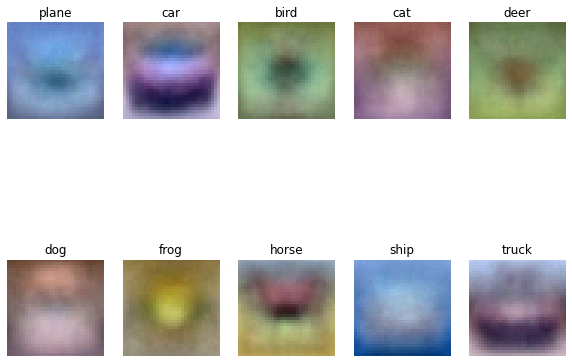

In [26]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])